Processing n=2...
average time for UCS : 0.0
average time for bidirectional : 0.0
Processing n=3...
average time for UCS : 0.867903208732605
average time for bidirectional : 0.011707282066345215


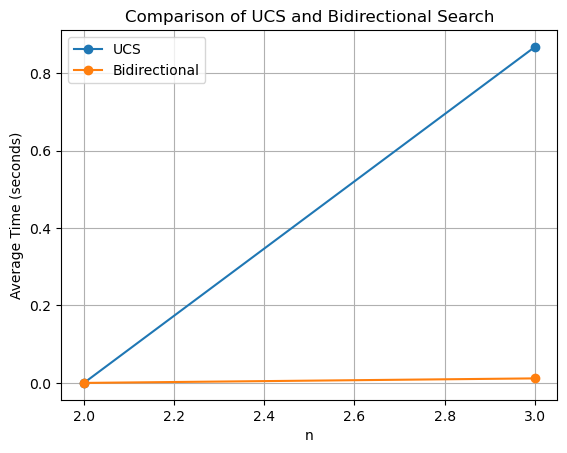

In [6]:
import time
import random
import heapq
from collections import deque
import matplotlib.pyplot as plt

def generate_solvable_state(n):
    while True:
        state = list(range(n * n))
        random.shuffle(state)
        if is_solvable(state, n):
            return tuple(state)

def is_solvable(state, n):
    inversion_count = 0
    state_list = [x for x in state if x != 0]
    for i in range(len(state_list)):
        for j in range(i + 1, len(state_list)):
            if state_list[i] > state_list[j]:
                inversion_count += 1
    blank_pos = state.index(0)
    row = blank_pos // n
    blank_row_from_bottom = n - 1 - row
    if n % 2 == 1:
        return (inversion_count % 2) == 0
    else:
        return (inversion_count + blank_row_from_bottom) % 2 == 0

def ucs_search(initial, goal, n, timeout):
    start_time = time.time()
    heap = []
    heapq.heappush(heap, (0, initial))
    visited = {initial: 0}
    while heap:
        current_cost, current_state = heapq.heappop(heap)
        if current_state == goal:
            return time.time() - start_time
        if time.time() - start_time > timeout:
            return None
        blank_pos = current_state.index(0)
        row = blank_pos // n
        col = blank_pos % n
        moves = []
        if row > 0:
            moves.append(-n)
        if row < n - 1:
            moves.append(n)
        if col > 0:
            moves.append(-1)
        if col < n - 1:
            moves.append(1)
        for move in moves:
            new_pos = blank_pos + move
            new_state = list(current_state)
            new_state[blank_pos], new_state[new_pos] = new_state[new_pos], new_state[blank_pos]
            new_state_tuple = tuple(new_state)
            new_cost = current_cost + 1
            if new_state_tuple not in visited or new_cost < visited[new_state_tuple]:
                visited[new_state_tuple] = new_cost
                heapq.heappush(heap, (new_cost, new_state_tuple))
    return None

def bidirectional_search(initial, goal, n, timeout):
    start_time = time.time()
    forward_queue = deque([(initial, 0)])
    forward_visited = {initial: 0}
    backward_queue = deque([(goal, 0)])
    backward_visited = {goal: 0}
    while forward_queue and backward_queue:
        if time.time() - start_time > timeout:
            return None
        if forward_queue:
            current_state, cost = forward_queue.popleft()
            if current_state in backward_visited:
                return time.time() - start_time
            blank_pos = current_state.index(0)
            row, col = divmod(blank_pos, n)
            moves = []
            if row > 0:
                moves.append(-n)
            if row < n - 1:
                moves.append(n)
            if col > 0:
                moves.append(-1)
            if col < n - 1:
                moves.append(1)
            for move in moves:
                new_pos = blank_pos + move
                new_state = list(current_state)
                new_state[blank_pos], new_state[new_pos] = new_state[new_pos], new_state[blank_pos]
                new_state_tuple = tuple(new_state)
                new_cost = cost + 1
                if new_state_tuple not in forward_visited or new_cost < forward_visited[new_state_tuple]:
                    forward_visited[new_state_tuple] = new_cost
                    forward_queue.append((new_state_tuple, new_cost))
        if time.time() - start_time > timeout:
            return None
        if backward_queue:
            current_state, cost = backward_queue.popleft()
            if current_state in forward_visited:
                return time.time() - start_time
            blank_pos = current_state.index(0)
            row, col = divmod(blank_pos, n)
            moves = []
            if row > 0:
                moves.append(-n)
            if row < n - 1:
                moves.append(n)
            if col > 0:
                moves.append(-1)
            if col < n - 1:
                moves.append(1)
            for move in moves:
                new_pos = blank_pos + move
                new_state = list(current_state)
                new_state[blank_pos], new_state[new_pos] = new_state[new_pos], new_state[blank_pos]
                new_state_tuple = tuple(new_state)
                new_cost = cost + 1
                if new_state_tuple not in backward_visited or new_cost < backward_visited[new_state_tuple]:
                    backward_visited[new_state_tuple] = new_cost
                    backward_queue.append((new_state_tuple, new_cost))
    return None

def main(n_values):
    timeout = 60  # 60 seconds
    num_problems = 10
    results = {n: {'ucs': [], 'bidirectional': []} for n in n_values}

    for n in n_values:
        print(f"Processing n={n}...")
        goal = tuple(list(range(1, n * n)) + [0])
        valid_problems = 0
        ucs_times = []
        bidirectional_times = []

        for _ in range(num_problems):
            initial = generate_solvable_state(n)
            ucs_time = None
            bidirectional_time = None

            # Run UCS
            start_time = time.time()
            ucs_result = ucs_search(initial, goal, n, timeout)
            if ucs_result is not None:
                ucs_time = ucs_result

            # Run Bidirectional
            start_time = time.time()
            bidirectional_result = bidirectional_search(initial, goal, n, timeout)
            if bidirectional_result is not None:
                bidirectional_time = bidirectional_result

            # Check if at least one succeeded
            if ucs_time is not None or bidirectional_time is not None:
                valid_problems += 1
                if ucs_time is not None:
                    ucs_times.append(ucs_time)
                if bidirectional_time is not None:
                    bidirectional_times.append(bidirectional_time)

        # Store results
        if valid_problems > 0:
            avg_ucs = sum(ucs_times) / len(ucs_times) if ucs_times else 0
            avg_bidirectional = sum(bidirectional_times) / len(bidirectional_times) if bidirectional_times else 0
            print(f"average time for UCS : {avg_ucs}")
            print(f"average time for bidirectional : {avg_bidirectional}")
            results[n]['ucs'].append(avg_ucs)
            results[n]['bidirectional'].append(avg_bidirectional)
        else:
            print(f"No valid problems for n={n}")

    # Prepare data for plotting
    x = n_values
    y_ucs = [sum(results[n]['ucs'])/len(results[n]['ucs']) if results[n]['ucs'] else 0 for n in n_values]
    y_bidirectional = [sum(results[n]['bidirectional'])/len(results[n]['bidirectional']) if results[n]['bidirectional'] else 0 for n in n_values]

    plt.figure()
    plt.plot(x, y_ucs, label='UCS', marker='o')
    plt.plot(x, y_bidirectional, label='Bidirectional', marker='o')
    plt.xlabel('n')
    plt.ylabel('Average Time (seconds)')
    plt.title('Comparison of UCS and Bidirectional Search')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    n_values = [2,3]  # Example input
    main(n_values)